In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import states_pipeline
from scipy import stats

### Running example - S. aureus expression data set

The data set used in this example was taken from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE16129
all the files used are in the example folder

#### Step 1

Reading the data files and formatting as a valid input for the pipeline

In [2]:
expression_table = pd.read_csv('example/s aureus expression.csv',index_col=0)

Create a list of controls

*Note that the control list should match the columns format


In [3]:
individuals = pd.read_csv('example/individuals_info.csv',index_col=0)

In [4]:
control_individuals = individuals[individuals['!Sample_source_name_ch1'] == 'PBMC_Healthy']['!Sample_geo_accession']
control_individuals #list of control individuals

PBMC Healthy Control INF 11N HG-U133A    GSM403284
PBMC Healthy Control INF 23N HG-U133A    GSM403304
PBMC Healthy Control INF 24N HG-U133A    GSM403312
PBMC Healthy Control INF 294 HG-U133A    GSM403322
PBMC Healthy Control INF 301 HG-U133A    GSM403326
PBMC Healthy Control INF 303 HG-U133A    GSM403328
PBMC Healthy Control INF 304 HG-U133A    GSM403330
PBMC Healthy Control INF 3N HG-U133A     GSM403411
PBMC Healthy Control INF 7N HG-U133A     GSM403546
PBMC Healthy Control INF 8N HG-U133A     GSM403551
Name: !Sample_geo_accession, dtype: object

*In this example, the controls are healthy individuals but you can use any group of individuals you want the states to be centered based on. For example: time 0 in time series data or patients who did not take any drug


#### Step 2: read the maps

In [5]:
T_R_map = pd.read_csv('resistance_tolerance_map.csv',index_col=0)
mets_SI_map = pd.read_csv('MetS_systemic_inflammation_map.csv',index_col=0)

#### Step 3: data preprocessing

In [6]:
expression_df = states_pipeline.expression_preproccesing(expression_table,control_individuals)

### Step 4: states calculation

In [7]:
r_t_states = states_pipeline.states_df(T_R_map,'T','R',expression_df)
mets_si_states = states_pipeline.states_df(mets_SI_map,'MetS','SI',expression_df)
full_states_table = r_t_states.join(mets_si_states)

lets see what we got

In [8]:
full_states_table.head()

,T state,R state,pval T,pval R,const T R map,MetS state,SI state,pval MetS,pval SI,const MetS SI map
individual,,,,,,,,,,
GSM403282,0.970590,-0.014223,1.374340e-07,2.340323e-80,-0.067617,0.000665,0.034345,3.237093e-19,8.354465e-01,-0.140356
GSM403284,0.360855,-0.131939,3.664863e-03,1.139160e-27,0.024270,0.015036,-0.010186,1.046635e-06,4.533459e-14,0.047464
GSM403286,1.545399,0.022305,8.962615e-13,1.528181e-54,-0.178819,0.016462,0.117756,6.034198e-87,7.595334e-03,-0.601964
GSM403288,1.093879,1.009495,6.115751e-05,1.724262e-34,-0.090279,0.000670,0.102322,9.711531e-40,9.063974e-01,-0.368695
GSM403290,1.311292,0.926360,5.944721e-04,2.525650e-47,-0.078476,0.011984,0.144313,4.893973e-30,3.011190e-02,-0.308376


This is the states table for the T/R map and the MetS SI map with the corresponding p values. you can see how the calculation was done in the function state_pipline.states_df

#### Step 5: Standartization of the calculated levels based on the controls

This is an important step so that you could compare states for different maps (like SI and R later in the pipeline) and also to compare states from different data sets


In [9]:
full_states_table = states_pipeline.norm_all_states(full_states_table,control_individuals)

#### Step 6: R/SI balance score calculation

In [10]:
full_states_table = states_pipeline.R_SI_balance_score(full_states_table)

Now we have the final results. lets take a look:

In [11]:
full_states_table = pd.merge(full_states_table,individuals,left_index=True,right_on='!Sample_geo_accession')
full_states_table.head()

,T state,R state,pval T,pval R,const T R map,MetS state,SI state,pval MetS,pval SI,const MetS SI map,...,!Sample_contact_email,!Sample_contact_institute,!Sample_contact_address,!Sample_contact_city,!Sample_contact_state,!Sample_contact_zip/postal_code,!Sample_contact_country,!Sample_supplementary_file,!Sample_data_row_count,!Sample_relation
PBMC S. aureus INF 109 HG-U133A,1.874971,-0.070304,1.374340e-07,2.340323e-80,-0.067617,0.030162,1.721609,3.237093e-19,8.354465e-01,-0.140356,...,DChaussabel@benaroyaresearch.org,Baylor Institute for Immunology Research,3434 Live Oak,Dallas,TX,75204,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM403n...,22283,Reanalyzed by: GSE122505
PBMC Healthy Control INF 11N HG-U133A,0.697094,-0.652146,3.664863e-03,1.139160e-27,0.024270,0.682180,-0.510587,1.046635e-06,4.533459e-14,0.047464,...,DChaussabel@benaroyaresearch.org,Baylor Institute for Immunology Research,3434 Live Oak,Dallas,TX,75204,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM403n...,22283,Reanalyzed by: GSE122505
PBMC S. aureus INF 150 HG-U133A,2.985380,0.110248,8.962615e-13,1.528181e-54,-0.178819,0.746839,5.902807,6.034198e-87,7.595334e-03,-0.601964,...,DChaussabel@benaroyaresearch.org,Baylor Institute for Immunology Research,3434 Live Oak,Dallas,TX,75204,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM403n...,22283,Reanalyzed by: GSE122505
PBMC S. aureus INF 179 HG-U133A,2.113140,4.989735,6.115751e-05,1.724262e-34,-0.090279,0.030377,5.129144,9.711531e-40,9.063974e-01,-0.368695,...,DChaussabel@benaroyaresearch.org,Baylor Institute for Immunology Research,3434 Live Oak,Dallas,TX,75204,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM403n...,22283,Reanalyzed by: GSE122505
PBMC S. aureus INF 205 HG-U133A,2.533135,4.578816,5.944721e-04,2.525650e-47,-0.078476,0.543712,7.234080,4.893973e-30,3.011190e-02,-0.308376,...,DChaussabel@benaroyaresearch.org,Baylor Institute for Immunology Research,3434 Live Oak,Dallas,TX,75204,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM403n...,22283,Reanalyzed by: GSE122505


Now you can use your R/SI final score for some downstream analysis

<AxesSubplot: xlabel='!Sample_source_name_ch1', ylabel='R/SI balance score'>

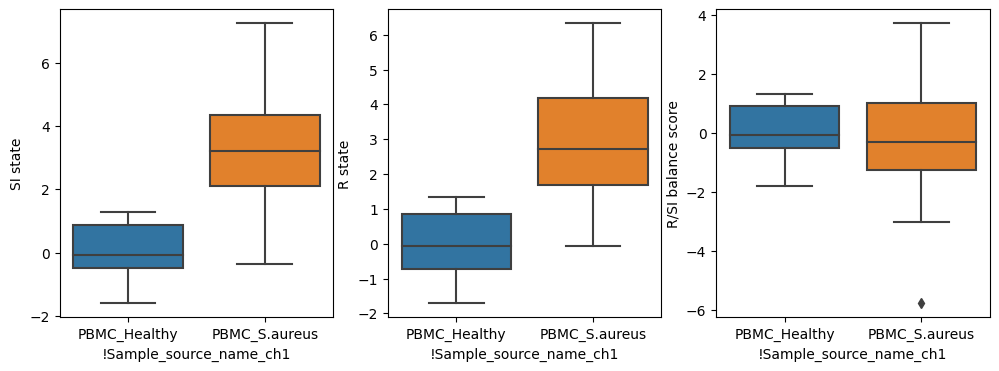

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (12,4))
sns.boxplot(data = full_states_table,y='SI state',x='!Sample_source_name_ch1',ax=ax1,order = ('PBMC_Healthy','PBMC_S.aureus')) #box plot the SI state of healthy controls and in s aureus patients
sns.boxplot(data = full_states_table,y='R state',x='!Sample_source_name_ch1',ax=ax2,order = ('PBMC_Healthy','PBMC_S.aureus')) #box plot the R state of healthy controls and in s aureus patients
sns.boxplot(data = full_states_table,y='R/SI balance score',x='!Sample_source_name_ch1',ax=ax3,order = ('PBMC_Healthy','PBMC_S.aureus')) #box plot the R/SI balance score of healthy controls and in s aureus patient

In [13]:
sick_states =full_states_table[full_states_table['!Sample_source_name_ch1'] == 'PBMC_S.aureus']
healthy_states =full_states_table[full_states_table['!Sample_source_name_ch1'] == 'PBMC_Healthy']

differential SI,R and R/SI balance score  (sick vs healthy individuals)

In [14]:
stats.ttest_ind(sick_states['SI state'],healthy_states['SI state'])

Ttest_indResult(statistic=5.9176000357840515, pvalue=2.3110137832428907e-07)

In [15]:
stats.ttest_ind(sick_states['R state'],healthy_states['R state'])

Ttest_indResult(statistic=5.639918840282906, pvalue=6.400184913458083e-07)

In [16]:
stats.ttest_ind(sick_states['R/SI balance score'],healthy_states['R/SI balance score'])

Ttest_indResult(statistic=-0.3876076055888322, pvalue=0.6998300884703385)

Here i did a simple analysis to compare the SI state, R state and R/SI balance score of healthy and sick individuals

#### Run the full pipeline

In this example ran the pipeline step by step to show how to use it flexibly (now you can use the states calculation on a different gene maps).
If you want to run the full pipeline easily you can simply use the function: full_R_SI_score_pipeline(expression_table,control_individuals) as follows:

In [17]:
full_states_table = states_pipeline.full_R_SI_score_pipeline(expression_table,control_individuals)
full_states_table.head()

,T state,R state,pval T,pval R,const T R map,MetS state,SI state,pval MetS,pval SI,const MetS SI map,R/SI balance score
individual,,,,,,,,,,,
GSM403282,1.874971,-0.070304,1.374340e-07,2.340323e-80,-0.067617,0.030162,1.721609,3.237093e-19,8.354465e-01,-0.140356,-1.791913
GSM403284,0.697094,-0.652146,3.664863e-03,1.139160e-27,0.024270,0.682180,-0.510587,1.046635e-06,4.533459e-14,0.047464,-0.141559
GSM403286,2.985380,0.110248,8.962615e-13,1.528181e-54,-0.178819,0.746839,5.902807,6.034198e-87,7.595334e-03,-0.601964,-5.792559
GSM403288,2.113140,4.989735,6.115751e-05,1.724262e-34,-0.090279,0.030377,5.129144,9.711531e-40,9.063974e-01,-0.368695,-0.139408
GSM403290,2.533135,4.578816,5.944721e-04,2.525650e-47,-0.078476,0.543712,7.234080,4.893973e-30,3.011190e-02,-0.308376,-2.655265
